In [15]:
from transformers import BertTokenizerFast
import re 
import sys
import os
sys.path.append(os.path.join(os.path.dirname("."), '../..'))

import mapillm
from mapillm.mapi_tools import MAPI_reg_tools
from datasets import load_dataset

from dotenv import load_dotenv
load_dotenv("../.env")


True

In [16]:
dataset=load_dataset('ur-whitelab/mapi', token=os.environ['HF_TOKEN'])

print(dataset['train'].column_names)

target = ["band_gap"]
# features=['formula_pretty', 'crystal_system', 'symbol', 'point_group']
features=['formula_pretty', 'crystal_system', 'point_group']


['nsites', 'nelements', 'formula_pretty', 'chemsys', 'volume', 'density', 'density_atomic', 'property_name', 'material_id', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'bulk_modulus', 'shear_modulus', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic', 'n', 'e_ij_max', 'weighted_surface_energy_EV_PER_ANG2', 'weighted_surface_energy', 'weighted_work_function', 'surface_anisotropy', 'shape_factor', 'has_reconstructed', 'has_props', '

In [17]:
train_dataset = dataset['train'].select_columns(features+target)
test_dataset = dataset['test'].select_columns(features+target)

def filter_none(example):
    return all(value is not None for value in example.values())

train_dataset = train_dataset.filter(filter_none).to_pandas()
test_dataset = test_dataset.filter(filter_none).to_pandas()

In [18]:
from langchain.prompts.prompt import PromptTemplate
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.example_selector import (MaxMarginalRelevanceExampleSelector, 
                                                SemanticSimilarityExampleSelector)
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings


examples = train_dataset.astype(str).drop_duplicates().dropna().to_dict(orient="records")

example_selector = MaxMarginalRelevanceExampleSelector.from_examples(
                examples,
                OpenAIEmbeddings(),
                FAISS,
                k=10,
                )

prompt_template=PromptTemplate(
                  input_variables=["crystal_system", "formula_pretty", "point_group", "band_gap"],
                  template=f"What is the band_gap for {{crystal_system}} {{formula_pretty}} with space group {{point_group}}?@@@\n{{band_gap}}###"
              )
    
prefix=(
    f'You are a bot who can predict the band_gap of a material .\n'
    f'Given this list of known materials and the measurement of their band gap, \n'
    f'you need to predict what is the band gap of the material:'
    f'The answer should be numeric and finish with ###'
    )
suffix = f"What is the band_gap for {{crystal_system}} {{formula_pretty}} with space group {{point_group}}?@@@\n"
prompt = FewShotPromptTemplate(
            # examples=examples,
            example_prompt=prompt_template,
            example_selector=example_selector,
            prefix=prefix,
            suffix=suffix,
            input_variables=["crystal_system", "formula_pretty", "point_group"])


In [19]:
band_gap_tool = MAPI_reg_tools(
    "band_gap","band gap"
)
tools = band_gap_tool.get_tools()
for k in tools:
    print(f"{k.name}\n\t{k.description}")
get_material_atoms    = tools[0].func
check_prop_by_formula = tools[1].func
create_context_prompt = tools[2].func
LLM_predict           = tools[3].func

# I want to evaluate the tools doing something like that. But as the tools aren't ready, I'll just evaluate the ICL
# check_prop_by_formula(formula = "LiCoO2")
# get_material_atoms(formula = "LiCoO2")
# prompt = create_context_prompt(formula = "LiCoO2")
# print(prompt)
# LLM_predict(prompt=prompt)

Get atoms in material
	Receives a material formula and returns the atoms symbols present in it separated by comma.
Checks if material is band gap by formula
	This functions searches in the material project's API for the formula and returns if it is band gap or not.
Create band gap context to LLM search
	This function received a material formula as input and create a prompt to be inputed in the LLM_predict tool to predict the band gap of a material.
LLM prediction
	This function receives a prompt generate with context by the create_context_prompt tool and request a completion to a language model. Then returns the completion


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import matplotlib as mpl
import matplotlib.font_manager as font_manager
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True
           })

In [21]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
          model_name="gpt-3.5-turbo-0125",
          temperature=0.1,
          n=5,
          # best_of=5,
          # stop=["\n\n", "###", "#", "##"],
      )

In [22]:
k=8

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

yhat=[]
y=[]
for k in range(100):
    try:
        y.append(test_dataset.iloc[k][target])
        
        formula_pretty = test_dataset.iloc[k]["formula_pretty"]
        crystal_system = test_dataset.iloc[k]["crystal_system"]
        point_group = test_dataset.iloc[k]["point_group"]

        p = prompt.format(crystal_system=crystal_system,
                          formula_pretty=formula_pretty,
                          point_group=point_group
                          )
        completion = llm.invoke([p]).content
        pred = float(re.findall(r"[-+]?\d*\.\d+|\d+", completion)[0])
        yhat.append(pred)
    except Exception as e:
        print(k, e)
        yhat.append(-1)

y = np.array(y).astype(float).flatten()
yhat = np.array(yhat).astype(float).flatten()
print(y.shape, yhat.shape)

(100,) (100,)


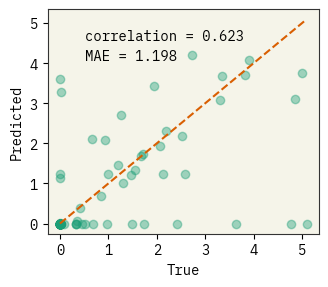

In [23]:
lim = (min(y),max(y))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(y, yhat, 'o', alpha=0.4)
plt.plot(lim, lim, '--')
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 1*0.1*(max(y)-min(y)), f"correlation = {np.corrcoef(y, yhat)[0,1]:.3f}")
plt.text(lim[0] + 0.1*(max(y)-min(y)), lim[1] - 2*0.1*(max(y)-min(y)), f"MAE = {mean_squared_error(y, yhat):.3f}")
plt.show()
